In [60]:
import pandas as pd
import numpy as np
import os
import json
import csv
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import text_to_word_sequence
from sklearn.decomposition import PCA
try:
    from MulticoreTSNE import MulticoreTSNE as TSNE
except:
    print("For reasonable computation time, install Multicore-TSNE!")
    from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import re
import heapq
import gc
#import nltk
#from nltk.corpus import stopwords
import tensorflow as tf
import tensorflow_hub as hub
import requests
from DreamScrape.extract import DREAMERS as dream_series_ids
from html.parser import HTMLParser
import seaborn as sns
import scipy.spatial

#nltk.download('stopwords')
#stop = set(stopwords.words('english'))
%matplotlib notebook
plt.rcParams['figure.figsize'] = (10, 10)

In [61]:
# Read dreams from DreamScrape
dreams = []

def maybeNone(d, key):
    try:
        return d[key]
    except:
        return None

dreamsdir = "DreamScrape/dreams"
for filename in os.listdir(dreamsdir):
    with open(dreamsdir + "/" + filename) as f:
        d = json.load(f)
        dreams.append(pd.DataFrame({
            "dream_series_id": d["dreamer"],
            "content": [maybeNone(dream,"content") for dream in d["dreams"]],
            "head":    [maybeNone(dream,"head"   ) for dream in d["dreams"]],
        }))
    
dreams = pd.concat(dreams)
gc.collect()

30506

In [62]:
# Keep only english series!
german_dream_series = [dreamer for dreamer in dreams["dream_series_id"].value_counts().keys() if ".de" in dreamer]

def is_not_german(dream_series_id):
    return dream_series_id not in german_dream_series
dreams["is_not_german"] = dreams["dream_series_id"].apply(is_not_german)

dreams = dreams[dreams["is_not_german"]]
dreams.drop(columns=["is_not_german"], inplace=True)

In [63]:
# Get Dream Series Info

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

def get_info(dream_series_id):
    """
    Hacky-ass code... nothing to see here!
    """
    response = requests.get("http://www.dreambank.net/more_info.cgi?mode=AND&query=&filter=&submitted=1&frames=0&series=" + dream_series_id + "&more_info=more%20info&ss=100&subtotals=1&rd_table=1&cs=").text
    response = response.split('<body bgcolor="#ffffff" text="#000000">')[1]
    response = response.replace("\n","")
    
    head = response.split("<br><br>")[0]    
    head = strip_tags(head.replace("<br>", "\n"))
    head = head.split("\n")
    series = head[0].replace("Dream series: ", "")
    n_dreams = head[1].split(": ")[1]
    year = head[2].split(": ")[1]
    sex = head[3].split(": ")[1]
    description = strip_tags(response.split("<br><br>")[1].replace("<br>", "\n"))
    description = description.replace("[Back to search form]", "")
    
    return {
        "dream_series_id": dream_series_id,
        "series": series,
        "n_dreams": n_dreams,
        "year": year,
        "sex": sex,
        "description": description,
    }


info = pd.DataFrame(
    [get_info(dream_series_id) for dream_series_id in dream_series_ids if is_not_german(dream_series_id)])

In [64]:
# Fix Jasmine Description
desc = info[info["dream_series_id"] == "jasmine1"]["description"].values[0]
info.loc[info["dream_series_id"] == "jasmine2", "description"] = desc
info.loc[info["dream_series_id"] == "jasmine3","description"] = desc
info.loc[info["dream_series_id"] == "jasmine4", "description"] = desc

In [48]:
info.to_csv("info.csv", index=False)
dreams.to_csv("dreams.csv", index=False)
gc.collect()

34

### Tensorflow Hub Module for Universal Sentence Encodings

In [8]:
g = tf.Graph() 
with g.as_default(): 
    input_sentences = tf.placeholder(tf.string, shape=[None]) 
    embedder = hub.Module("https://tfhub.dev/google/universal-sentence-encoder/1") 
    sentence_batch = embedder(input_sentences) 
    table_op = tf.tables_initializer() 
    var_op = tf.global_variables_initializer() 
    g.finalize() 

In [9]:
vecs = np.zeros((len(dreams),512))
with tf.Session(graph=g) as session: 
    session.run([var_op, table_op]) 
    i=0
    step = 1
    while i < len(messages):
        sentences = messages[i*step:(i+1)*step]
        try:
            vecs[i*step:(i+1)*step] = session.run(sentence_batch, feed_dict={input_sentences: sentences})
        except:
            print(sentences)
        i += step

In [10]:
np.save("sem_sim_vecs.npy", vecs)

### Dimensionality Reduction

In [65]:
vecs = np.load("sem_sim_vecs.npy")
dreams = pd.read_csv("dreams.csv")

In [66]:
def plot(dim_red_technique, n=30, n_per_series=200):
    fig, ax = plt.subplots()
    
    series = dreams["dream_series_id"].value_counts().keys()[:n]
    
    for i, series_id in enumerate(series):
        
        ind = dreams["dream_series_id"] == series_id
        
        scatter = dreams[ind][:n_per_series]
        
        ax.scatter(
            scatter["x_" + dim_red_technique], 
            scatter["y_" + dim_red_technique], 
            color=np.random.uniform(size=3), 
            label=series_id, alpha = 0.5)
        
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=5)

def normalize(vec):
    return (vec - np.mean(vec)) / np.std(vec)

<IPython.core.display.Javascript object>


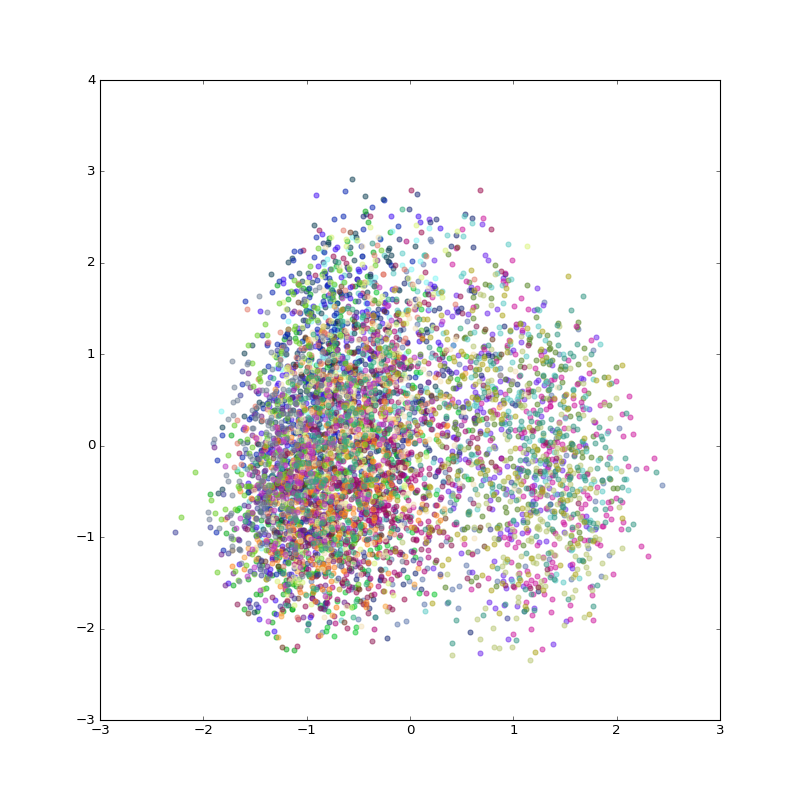

In [67]:
pca = PCA(n_components=2)
vecs_2dim = pca.fit_transform(vecs)
dreams["x_pca"] = normalize(vecs_2dim[:,0])
dreams["y_pca"] = normalize(vecs_2dim[:,1])
plot("pca")

In [13]:
try:
    tsne = TSNE(n_components=2, n_iter=20000, perplexity=100, n_jobs=4, verbose=1)
except:
    print("For reasonable computation time, install Multicore-TSNE!")    
    tsne = TSNE(n_components=2, n_iter=20000, perplexity=100)
vecs_2dim = tsne.fit_transform(vecs)
dreams["x_tsne"] = normalize(vecs_2dim[:,0])
dreams["y_tsne"] = normalize(vecs_2dim[:,1])


<IPython.core.display.Javascript object>


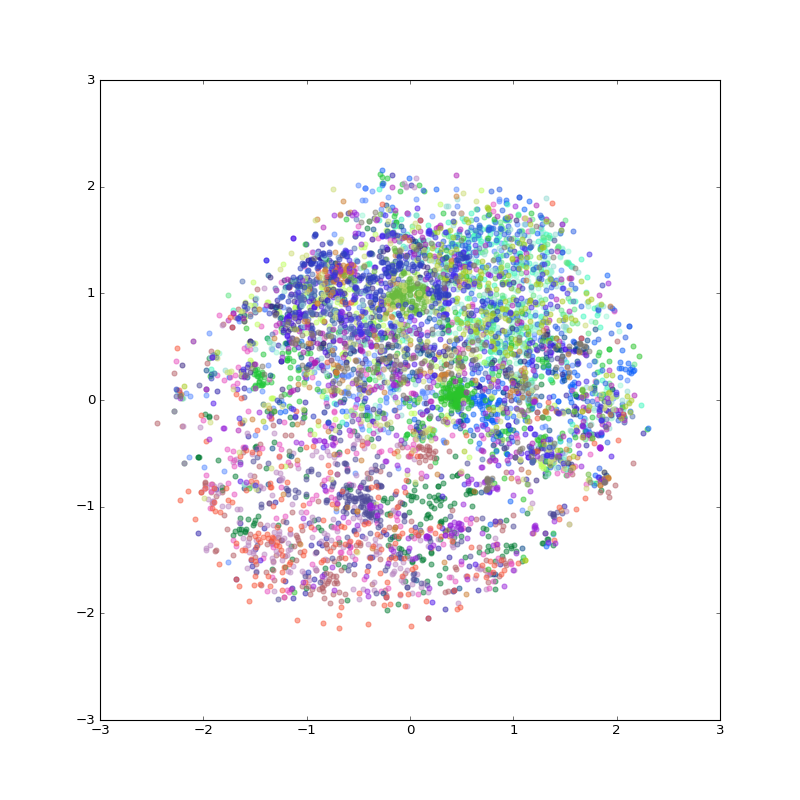

In [68]:
plot("tsne")

In [69]:
from keras.layers import Dense
from keras import regularizers
from keras import optimizers
from keras.layers import Dropout
from keras import Input
from keras.layers import Activation
from keras.models import Model
from keras.layers.normalization import BatchNormalization

class AutoEncoder:
        
    def __init__(self):
        dream_vector = Input(shape=(vecs.shape[1],))
        encoded = Dense(200)(dream_vector)
        encoded = BatchNormalization()(encoded)
        encoded = Activation('softsign')(encoded)
        encoded = (Dropout(0.5))(encoded)

        encoded = Dense(100)(encoded)
        encoded = BatchNormalization()(encoded)
        encoded = Activation('softsign')(encoded)
        encoded = (Dropout(0.5))(encoded)
    
        encoded = Dense(50)(encoded)
        encoded = BatchNormalization()(encoded)
        encoded = Activation('softsign')(encoded)
        
        encoded = Dense(2)(encoded)
        decoded = Activation('softsign')(encoded)

        decoded = Dense(50)(encoded)
        decoded = BatchNormalization()(decoded)
        decoded = Activation('softsign')(decoded)
        decoded = (Dropout(0.5))(decoded)
        
        decoded = Dense(100)(encoded)
        decoded = BatchNormalization()(decoded)
        decoded = Activation('softsign')(decoded)
        decoded = (Dropout(0.5))(decoded)

        decoded = Dense(200)(encoded)
        decoded = BatchNormalization()(decoded)
        decoded = Activation('softsign')(decoded)
        decoded = (Dropout(0.5))(decoded)
        
        decoded = Dense(vecs.shape[1])(decoded)

        self.autoencoder = Model(dream_vector, decoded)
        self.encoder = Model(dream_vector, encoded)
        self.optimizer = optimizers.Adam(lr=0.00001, clipnorm=1., clipvalue=0.5)
        self.autoencoder.compile(loss="mse", optimizer=self.optimizer)
        
    def fit(self, X, epochs=300):
        X_ = X - np.mean(X, axis=0)
        X_ = X_ / np.std(X, axis=0)
        history = self.autoencoder.fit(
                    X_, 
                    X_, 
                    epochs=epochs, 
                    batch_size=32, 
                    verbose=1, 
                    shuffle=True)
        
    def transform(self, X):
        X_ = X - np.mean(X, axis=0)
        X_ = X_ / np.std(X, axis=0)

        return self.encoder.predict(X_)
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [70]:
vecs_2dim = AutoEncoder().fit_transform(vecs)
dreams["x_autoencoder"] = normalize(vecs_2dim[:,0])
dreams["y_autoencoder"] = normalize(vecs_2dim[:,1])

Epoch 1/300
26343/26343 [==============================] - 12s 437us/step - loss: 1.1300
Epoch 2/300
26343/26343 [==============================] - 10s 393us/step - loss: 1.0742
Epoch 3/300
26343/26343 [==============================] - 12s 446us/step - loss: 1.0348
Epoch 4/300
26343/26343 [==============================] - 9s 347us/step - loss: 1.0103
Epoch 5/300
26343/26343 [==============================] - 9s 352us/step - loss: 0.9977
Epoch 6/300
26343/26343 [==============================] - 10s 390us/step - loss: 0.9898
Epoch 7/300
26343/26343 [==============================] - 10s 374us/step - loss: 0.9830
Epoch 8/300
26343/26343 [==============================] - 9s 358us/step - loss: 0.9777
Epoch 9/300
26343/26343 [==============================] - 10s 364us/step - loss: 0.9734
Epoch 10/300
26343/26343 [==============================] - 9s 360us/step - loss: 0.9689
Epoch 11/300
26343/26343 [==============================] - 11s 410us/step - loss: 0.9650
Epoch 12/300
26343/2634

26343/26343 [==============================] - 8s 305us/step - loss: 0.8970
Epoch 93/300
26343/26343 [==============================] - 8s 304us/step - loss: 0.8968
Epoch 94/300
26343/26343 [==============================] - 8s 300us/step - loss: 0.8968
Epoch 95/300
26343/26343 [==============================] - 8s 305us/step - loss: 0.8966
Epoch 96/300
26343/26343 [==============================] - 8s 305us/step - loss: 0.8964
Epoch 97/300
26343/26343 [==============================] - 8s 298us/step - loss: 0.8962
Epoch 98/300
26343/26343 [==============================] - 8s 307us/step - loss: 0.8959
Epoch 99/300
26343/26343 [==============================] - 9s 358us/step - loss: 0.8960
Epoch 100/300
26343/26343 [==============================] - 11s 436us/step - loss: 0.8960
Epoch 101/300
26343/26343 [==============================] - 10s 370us/step - loss: 0.8959
Epoch 102/300
26343/26343 [==============================] - 10s 395us/step - loss: 0.8959
Epoch 103/300
26343/26343 [=

26343/26343 [==============================] - 9s 326us/step - loss: 0.8910
Epoch 183/300
26343/26343 [==============================] - 8s 323us/step - loss: 0.8909
Epoch 184/300
26343/26343 [==============================] - 8s 320us/step - loss: 0.8912
Epoch 185/300
26343/26343 [==============================] - 8s 308us/step - loss: 0.8910
Epoch 186/300
26343/26343 [==============================] - 8s 311us/step - loss: 0.8910
Epoch 187/300
26343/26343 [==============================] - 8s 313us/step - loss: 0.8910
Epoch 188/300
26343/26343 [==============================] - 8s 309us/step - loss: 0.8910
Epoch 189/300
26343/26343 [==============================] - 8s 313us/step - loss: 0.8909
Epoch 190/300
26343/26343 [==============================] - 9s 323us/step - loss: 0.8908
Epoch 191/300
26343/26343 [==============================] - 10s 385us/step - loss: 0.8907
Epoch 192/300
26343/26343 [==============================] - 9s 335us/step - loss: 0.8906
Epoch 193/300
26343/263

26343/26343 [==============================] - 10s 368us/step - loss: 0.8884
Epoch 273/300
26343/26343 [==============================] - 9s 338us/step - loss: 0.8882
Epoch 274/300
26343/26343 [==============================] - 9s 327us/step - loss: 0.8880
Epoch 275/300
26343/26343 [==============================] - 8s 320us/step - loss: 0.8880
Epoch 276/300
26343/26343 [==============================] - 9s 336us/step - loss: 0.8883
Epoch 277/300
26343/26343 [==============================] - 8s 318us/step - loss: 0.8880
Epoch 278/300
26343/26343 [==============================] - 9s 337us/step - loss: 0.8880
Epoch 279/300
26343/26343 [==============================] - 8s 313us/step - loss: 0.8882
Epoch 280/300
26343/26343 [==============================] - 8s 308us/step - loss: 0.8884
Epoch 281/300
26343/26343 [==============================] - 8s 314us/step - loss: 0.8877
Epoch 282/300
26343/26343 [==============================] - 10s 389us/step - loss: 0.8881
Epoch 283/300
26343/26

<IPython.core.display.Javascript object>


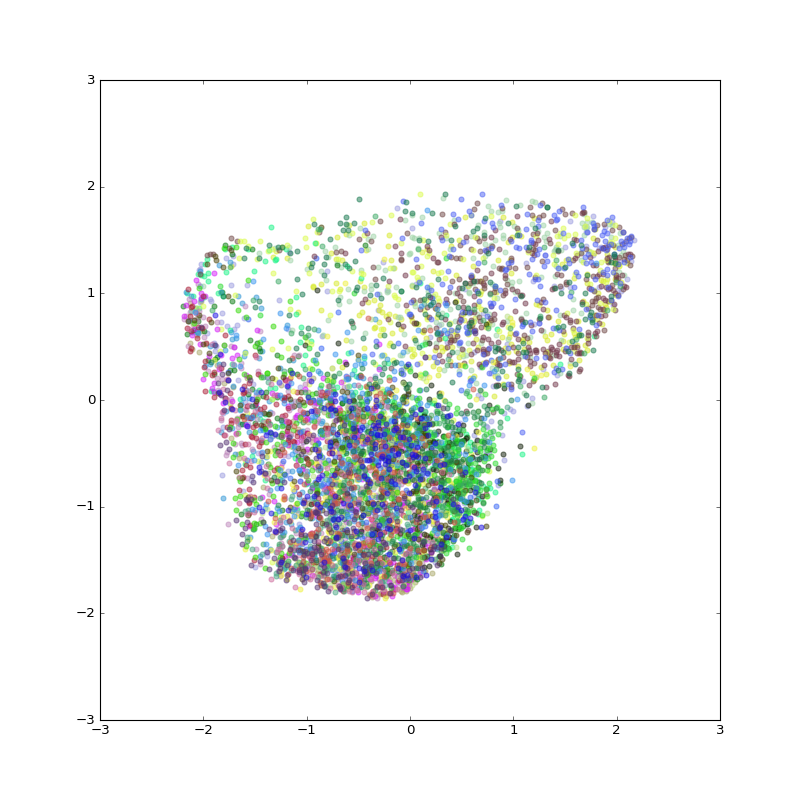

In [72]:
plot("autoencoder")

In [29]:
from keras.layers import Dense
from keras import regularizers
from keras import optimizers
from keras.layers import Dropout
from keras import Input
from keras.layers import Activation
from keras.models import Model
from keras.layers.normalization import BatchNormalization

class MFClassifier:
        
    def __init__(self):
        dream_vector = Input(shape=(vecs.shape[1],))
        model = Dense(512)(dream_vector)
        model = BatchNormalization()(model)
        model = Activation('tanh')(model)
        model = (Dropout(0.5))(model)

        model = Dense(256)(model)
        model = BatchNormalization()(model)
        model = Activation('tanh')(model)
        model = (Dropout(0.5))(model)

        model = Dense(256)(model)
        model = BatchNormalization()(model)
        model = Activation('tanh')(model)
        model = (Dropout(0.5))(model)

        model = Dense(256)(model)
        model = BatchNormalization()(model)
        model = Activation('tanh')(model)
        model = (Dropout(0.5))(model)

        model = Dense(256)(model)
        model = BatchNormalization()(model)
        model = Activation('tanh')(model)
        model = (Dropout(0.5))(model)
        
        model = Dense(2)(model)
        softmax = Activation('softmax')(model)
        
        self.model = Model(dream_vector, softmax)
        self.raw = Model(dream_vector, model)
        self.optimizer = optimizers.Adam(lr=0.0001, clipnorm=1., clipvalue=0.5)
        self.model.compile(loss="binary_crossentropy", optimizer=self.optimizer, 
                           metrics=["binary_accuracy"])
        
    def fit(self, X, y, epochs=100):
        
        frac_male = sum(y) / len(y)
        y_ = np.array([y, 1-y]).T
        X_ = X - np.mean(X, axis=0)
        X_ = X_ / np.std(X_, axis=0)
        #validation_data = (X_, y_)

        history = self.model.fit(
                    X_, 
                    y_, 
                    epochs=epochs, 
                    batch_size=32, 
                    verbose=1, 
                    #validation_data=validation_data, 
                    class_weight = {
                        0: 1 - frac_male,
                        1: frac_male
                    },
                    shuffle=True)
        
    def predict(self, X):
        X_ = X - np.mean(X, axis=0)
        return self.raw.predict(X_)

In [30]:
y = np.zeros(len(dreams))
y[dreams.merge(series_info, on="dream_series_id")["sex"] == "male"] = 1
clf = MFClassifier()
clf.fit(vecs, y)

Epoch 1/100
26343/26343 [==============================] - 20s 755us/step - loss: 0.3272 - binary_accuracy: 0.6017
Epoch 2/100
26343/26343 [==============================] - 17s 664us/step - loss: 0.2671 - binary_accuracy: 0.6877
Epoch 3/100
26343/26343 [==============================] - 18s 671us/step - loss: 0.2471 - binary_accuracy: 0.7139
Epoch 4/100
26343/26343 [==============================] - 18s 675us/step - loss: 0.2350 - binary_accuracy: 0.7298
Epoch 5/100
26343/26343 [==============================] - 18s 687us/step - loss: 0.2273 - binary_accuracy: 0.7381
Epoch 6/100
26343/26343 [==============================] - 18s 683us/step - loss: 0.2207 - binary_accuracy: 0.74764s - loss: 0.2206 - binary_ - ETA: 3s - loss: 0.2205 - binary_accuracy: 
Epoch 7/100
26343/26343 [==============================] - 18s 700us/step - loss: 0.2146 - binary_accuracy: 0.75501s - loss: 0.2147 - binary_accuracy - ETA: 1s - loss: 0.2144 - bin
Epoch 8/100
26343/26343 [==============================] 

In [31]:
vecs_2dim = clf.predict(vecs)
dreams["x_classifier"] = normalize(vecs_2dim[:,0])
dreams["y_classifier"] = normalize(vecs_2dim[:,1])


In [37]:
dreams.to_csv("dreams.csv", index=False)

### Using Google Cloud for Sentiment Analysis

In [67]:

# Imports the Google Cloud client library
from google.cloud import language
from google.cloud.language import enums
from google.cloud.language import types
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="../../My First Project-27bf8a653f12.json"

# Instantiates a client
client = language.LanguageServiceClient()

def get_sentiment(dream):
    try:
        document = types.Document(
            content=dream,
               type=enums.Document.Type.PLAIN_TEXT)

        # Detects the sentiment of the text
        sentiment = client.analyze_sentiment(document=document)
        
        return sentiment
    except:
        return "error";
    

In [69]:
if not os.path.exists("sentiment"):
    dream_contents = list(dreams["content"].values)
    # This is terrible sequential code which spends most of its time waiting
    # using a pool of requests can speed this up significantly
    responses = []
    for dream in dream_contents:
        if i%10==0:
            print(".", end="")
        if i%100==0:
            print(i)
        responses.append(get_sentiment(dream))
    
    import pickle
    with open("sentiment", "wb") as f:
        pickle.dump(responses, f)

In [71]:

import pickle
with open("sentiment", "wb") as f:
    pickle.dump(responses, f)

### Minor Data Preparation / Cleaning

In [31]:
dreams = pd.read_csv("dreams.csv")
info = pd.read_csv("info.csv")
import pickle
with open("sentiment", "rb") as f:
    responses = pickle.load(f)

In [16]:
dreams["sentiment_score"] = [x.document_sentiment.score for x in responses]
dreams["sentiment_magnitude"] = [x.document_sentiment.magnitude for x in responses]

In [17]:
"""
The hackiest of all hacky-assed codes - nothing to see here!
"""


from dateutil.parser import parse
from datetime import timedelta
import re
dates = []

for i,d in dreams.iterrows():
        
    if d["head"] and d["head"] is not np.NaN and "?" not in str(d["head"]):
        try:
            parsed_date = parse(d["head"])
            if parsed_date.year > 2018:
                parsed_date = parsed_date.replace(year=parsed_date.year - 100)
            dates.append(parsed_date)
            continue
        except Exception as e:
            None
        try:
            rep = d["head"].split()[0]
            try:
                dates.append(parse(rep))
            except:
                rep = re.sub("[^0-9]", "", rep)
                #print(rep)
                rep = rep[:2] + "/" + rep[2:4] + "/" + rep[4:]
                dates.append(parse(rep))

                continue
        except Exception as e:
            if d["head"] is not None:
                #print(rep, e)
                pass
            dates.append(None)

    else:
        content = d["content"]


        if (content.startswith("(")):
            datestr = content.split(")")[0].replace("(","")

            try:
                parsed_date = parse(datestr)
                dates.append(parsed_date)
            except Exception as e:
                
                try:
                    parsed_date = re.sub("[^0-9]", "", datestr)
                    dates.append(parse(parsed_date))
                except:
                    dates.append(None)
        else:
            dates.append(None)

In [18]:
dates_ = []
for d in dates:
    date = d
    if date is not None:
        if date.year < 600:
            date = date.replace(year = date.year + 900)
        if date.year < 1400:
            date = date.replace(year = date.year + 1000)
        elif 2190 < date.year:
            date = date.replace(year = date.year - 1000)
        if date.year >= 2018:
            date = date.replace(year = date.year - 100)
        if date.year >= 2018:
            date = date.replace(year = date.year - 100)

        if not (1880 < date.year < 2018):
            print(date)
    dates_.append(date)
dates = dates_
dreams["date"] = pd.to_datetime(pd.Series(dates))
index = (dreams["date"].dt.year>=2000) & (dreams["dream_series_id"]=="dorothea")
dreams.loc[index, "date"] = dreams.loc[index]["date"].apply(lambda x: x.replace(year=x.year - 100))

index = (dreams["dream_series_id"]=="ucsc_women")
dreams.loc[index, "date"] = dreams.loc[index]["date"].apply(lambda x: x.replace(year=1996))


In [34]:
print(dreams["date"].isnull().sum())

3406


In [74]:
dreams.to_csv("dreams.csv", index=False)

In [75]:
# Only keep necessary columns to keep website size small!
dreams.drop(columns=[
    "x_pca",
    "y_pca",
    "tsne_1d",
    "sentiment_magnitude",
]).to_csv("dreams_min.csv", index=False)

In [153]:
def nearest_neighbors(vecs, k):
    k_lst = range(2, k+2)
    tree = scipy.spatial.cKDTree(vecs)

    neighbors = []
    for i, row in enumerate(vecs):
        if i%100==0:
            print(".", end="")
        if i%1000==0:
            print(i)            
        dd, ii = tree.query(row, k=k_lst)
        neighbors.append(ii)
    return np.stack(neighbors)

In [154]:
neighbors = nearest_neighbors(vecs, 10)

.0
..........1000
..........2000
..........3000
..........4000
..........5000
..........6000
..........7000
..........8000
..........9000
..........10000
..........11000
..........12000
..........13000
..........14000
..........15000
..........16000
..........17000
..........18000
..........19000
..........20000
..........21000
..........22000
..........23000
..........24000
..........25000
..........26000
...

In [157]:
for i in range(10):
    dreams["neighbor_"+str(i)] = neighbors[:,i]